In [12]:
import sys
sys.path.append('..')

In [13]:
import time

import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import models
import custom_transforms
from datasets.sequence_folders import SequenceFolder
from radar_eval.eval_utils import RadarEvalOdom
import conversions as tgm

In [14]:
#sns.set(style=\"whitegrid\", rc={\"font.size\":8,\"axes.titlesize\":8,\"axes.labelsize\":5})
sn.set(style="whitegrid", font_scale=1.5)
sn.set_palette("bright", n_colors=4, color_codes=True)

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
torch.cuda.get_device_name(0)

cuda


'TITAN V'

In [33]:
weights_pose = torch.load("../checkpoints/resnet50_depth_256/02-19-08-37/exp_pose_checkpoint.pth.tar")
pose_net = models.PoseResNet(18).to(device)
pose_net.load_state_dict(weights_pose['state_dict'], strict=False)
pose_net.eval()

PoseResNet(
  (encoder): ResnetEncoder(
    (encoder): ResNetMultiImageInput(
      (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [34]:
# Data loading code
mean, std = 11.49, 16.46 #robotcar
# mean, std = 119.4501, 6.5258 # Calculated over all dataset
normalize = custom_transforms.Normalize(mean=mean, std=std)

# train_transform = custom_transforms.Compose([
#     custom_transforms.RandomHorizontalFlip(),
#     custom_transforms.RandomScaleCrop(),
#     custom_transforms.ArrayToTensor(),
#     normalize
# ])

# ds_transform = custom_transforms.Compose([custom_transforms.ArrayToTensor(), normalize])
ds_transform = custom_transforms.Compose([custom_transforms.ArrayToTensor()])

k=1
bs = 128
rangeResolutionsInMeter = 0.0432 # 0.0432-robotcar, 0.175-radiate, 0.0977-hand
angleResolutionInRad = 0.015708 #0.9deg
cart_pixels = 501
cart_res = 0.25

val_set = SequenceFolder(
        '/mnt/datasets/yasin/robotcar',
        transform=ds_transform,
        seed=12344,
        train=False,
        sequence_length=3,
        skip_frames=k,
        dataset='robotcar',
        cart_resolution = cart_res,
        cart_pixels = cart_pixels,
        rangeResolutionsInMeter=rangeResolutionsInMeter,
        angleResolutionInRad = angleResolutionInRad
    )

val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=bs, shuffle=False,
        num_workers=2, pin_memory=True)

In [35]:
#vo_eval = RadarEvalOdom('/mnt/datasets/yasin/records2-23mart2020/vicon-data-subsampled/vicon-gt-test1.csv')

In [36]:
def compute_pose_with_inv(pose_net, tgt_img, ref_imgs):
    poses = []
    poses_inv = []
    for ref_img in ref_imgs:
        poses.append(pose_net(tgt_img, ref_img))
        poses_inv.append(pose_net(ref_img, tgt_img))

    return torch.stack(poses), torch.stack(poses_inv)

In [37]:
all_poses = []
all_inv_poses = []

t_start = time.time()
with torch.no_grad():
    for i, (tgt_img, ref_imgs) in enumerate(val_loader):
        #(tgt_img, ref_imgs) = val_it.next()

        tgt_img = tgt_img.to(device)
        ref_imgs = [img.to(device) for img in ref_imgs]

        poses, poses_inv = compute_pose_with_inv(pose_net, tgt_img, ref_imgs)

        all_poses.append(poses)
        all_inv_poses.append(poses_inv)

        # gc.collect()
        # torch.cuda.empty_cache()
t_del = time.time() - t_start    

In [38]:
nframes = bs*len(val_loader)
print(len(all_poses))
print(nframes)
print(t_del)
print(t_del/nframes) # this for total of forward and backward poses

18
2304
122.7989890575409
0.05329817233400212


In [45]:
def getTraj(all_poses, all_inv_poses, k):
    """Convert the predicted poses to absolute trajectory. Each prediction in inputs is the relative pose for a sequence of [src_p, tgt, src_n].
    We form a trajectory from a chained sequence with k skip frames, e.g. [k, 2*k, 3*k, ..., N]. We shift the sequence by {i:i<k} to evaluate the full prediction.

    Args:
        all_poses (list): Predicted relative pose values for each src-to-tgt pair. List of torch.Tensor objects size [seq_length, B, 6]. rtvec=[rx, ry, rz, tx, ty, tz]
        all_inv_poses (list): Predicted relative pose values for each tgt-to-src pair. List of torch.Tensor objects.
        k (int): Skip frames. rtvec=[rx, ry, rz, tx, ty, tz]

    Returns:
        torch.Tensor: Backward and forward predicted trajectories
    """

    # pred = torch.zeros(self.gt.size(), dtype=self.gt.dtype, device = self.gt.device)
    all_poses_t = torch.cat(all_poses, 1) # [seq_length, N, 6]
    all_inv_poses_t = torch.cat(all_inv_poses, 1) # [seq_length, N, 6]
    
    #all_poses_t[:,:,0]=0.0
    #all_poses_t[:,:,1]=0.0
    #all_poses_t[:,:,5]=0.0

    N = all_poses_t.shape[1] #len(all_poses) # number of sequences

    i=0
    # for i in range(k):
    idx = torch.arange(i, N, k)
    
    # Previous src
    # TODO: Şimdilik forward pose alalım. ileride (forward-backward)/2 olmalı
    b_pose = (all_poses_t[0, idx] - all_inv_poses_t[0, idx])/2 # (src2tgt + inv(tgt2src))/2 [n,6]
    # b_pose = all_poses_t[0, idx] #src2tgt [n,6]
    b_pose = -b_pose # tgt2src [n,6]
    b_pose = tgm.rtvec_to_pose(b_pose) # tgt2src [n,4,4]
    # b_pose = tgm.inv_rigid_tform(b_pose) # tgt2src [n,4,4]
    
    # b_inv_pose = tgm.rtvec_to_pose(all_inv_poses_t[0, idx]) # inv(src2tgt) [n,4,4]            
    b_pose = rel2abs_traj(b_pose) # [n,4,4]
    # b_pose = b_pose.cumsum(dim=0) # [n,6] 

    # Next src
    # f_pose = tgm.rtvec_to_pose(all_poses_t[1, idx]) # tgt2src [n,4,4]
    # f_inv_pose = tgm.rtvec_to_pose(all_inv_poses_t[1, idx]) # inv(tgt2src) [n,4,4]
    # f_inv_pose = tgm.inv_rigid_tform(f_inv_pose) # inv(inv(tgt2src)) [n,4,4]
    # f_pose = (f_pose + f_inv_pose)/2 # (tgt2src + inv(inv(tgt2src)))/2 [n,4,4]
    # f_pose = rel2abs_traj(f_pose)
    f_pose = (all_poses_t[1, idx] - all_inv_poses_t[1, idx])/2 # (src2tgt + inv(tgt2src))/2 [n,6]
    # f_pose = all_poses_t[1, idx] #src2tgt [n,6]
    # f_pose = -f_pose # tgt2src [n,6]
    # f_pose = f_pose.cumsum(dim=0) # [n,6]
    f_pose = tgm.rtvec_to_pose(f_pose) # src2tgt [n,4,4]
    f_pose = rel2abs_traj(f_pose) # [n,4,4]
    # end for

    f_xyz = f_pose[:,:3,3]
    b_xyz = b_pose[:,:3,3]
    return b_xyz.squeeze(), f_xyz.squeeze()

def rel2abs_traj_old(rel_pose):
    """Convert a given relative pose sequences to absolute pose sequences.

    Args:
        rel_pose (torch.Tensor): Relative pose sequence in the form of homogenous transformation matrix. Shape: [N,4,4]

    Returns:
        torch.Tensor: Absolute pose sequence in the form of homogenous transformation matrix. Shape: [N,4,4]
    """

    abs_pose = rel_pose.clone()
    for i in range(1,abs_pose.shape[0]):
        abs_pose[i] = abs_pose[i] @ abs_pose[i-1]

    return abs_pose

def rel2abs_traj(rel_pose):
    """Convert a given relative pose sequences to absolute pose sequences.

    Args:
        rel_pose (torch.Tensor): Relative pose sequence in the form of homogenous transformation matrix. Shape: [N,4,4]

    Returns:
        torch.Tensor: Absolute pose sequence in the form of homogenous transformation matrix. Shape: [N,4,4]
    """
    global_pose = torch.eye(4).to(device)
    abs_pose = torch.zeros_like(rel_pose)    
    for i in range(rel_pose.shape[0]):
        global_pose = global_pose @ rel_pose[i]
        abs_pose[i] = global_pose

    return abs_pose


In [40]:
b_pred_xyz, f_pred_xyz = getTraj(all_poses, all_inv_poses, k)

In [41]:
print(f_pred_xyz.shape)

torch.Size([2249, 3])


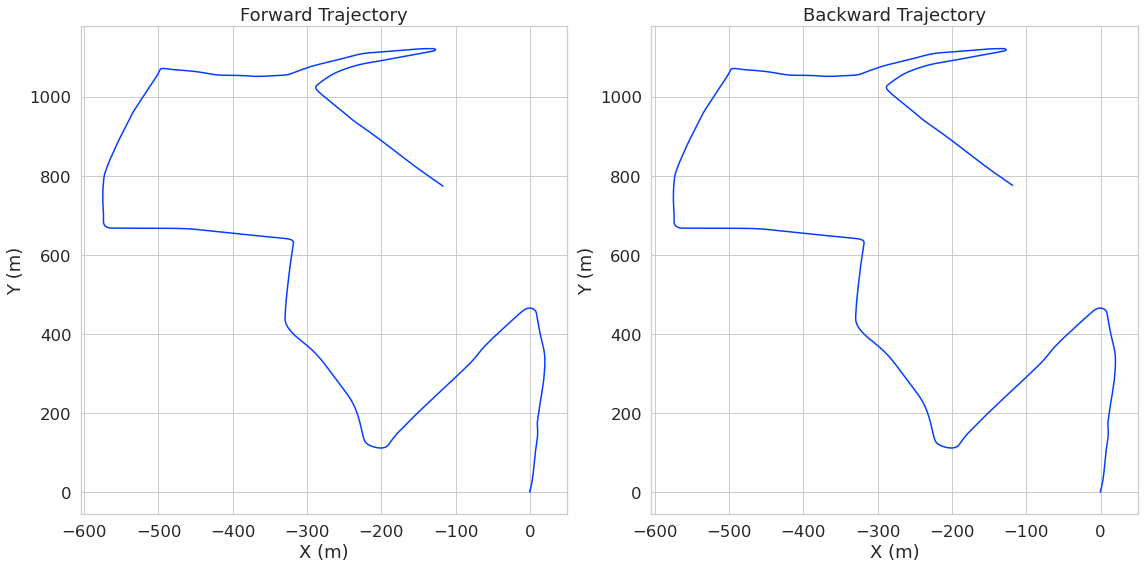

In [42]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
ax = sn.lineplot(x=f_pred_xyz[:,0].cpu().numpy(), y=f_pred_xyz[:,1].cpu().numpy(), sort=False)
ax.set(title='Forward Trajectory', xlabel='X (m)', ylabel='Y (m)')
plt.subplot(1,2,2)
ax = sn.lineplot(x=b_pred_xyz[:,0].cpu().numpy(), y=b_pred_xyz[:,1].cpu().numpy(), sort=False, markers=True)
ax.set(title='Backward Trajectory', xlabel='X (m)', ylabel='Y (m)')

# Save fig
plt.tight_layout()
plt.savefig('figs/ro_pred.pdf', bbox_inches = 'tight', pad_inches = 0)

# Read GT

In [24]:
f_gt = '/mnt/datasets/yasin/robotcar/2019-01-10-14-36-48-radar-oxford-10k-partial/gt/radar_odometry.csv'
gt = np.genfromtxt(f_gt, delimiter=',', usecols=np.arange(2,8), skip_header=True)
gt[:,np.arange(6)] = gt[:,[3,4,5,0,1,2]] # [rx,ry,rz,x,y,x] format
print(gt.shape)

(2249, 6)


In [25]:
print(gt[0])

[-0.00e+00 -0.00e+00  1.10e-05  2.69e-04 -2.70e-04 -0.00e+00]


In [28]:
gt_t = torch.Tensor(gt).to(device) # [n,6]
gt_t = tgm.rtvec_to_pose(gt_t) # [n,4,4]
gt_t = rel2abs_traj(gt_t) # [n,4,4]
gt_xyz = gt_t[:,:3,3] # [n,3]
gt_xyz = gt_xyz.cpu().numpy()

In [29]:
print(gt_xyz[:,0])

[2.6900001e-04 1.4360012e-03 2.4210014e-03 ... 6.4725647e+02 6.4486066e+02
 6.4244568e+02]


<AxesSubplot:>

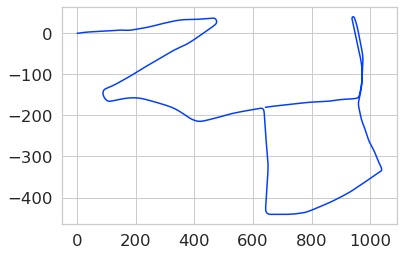

In [30]:
sn.lineplot(x=gt_xyz[:,0], y=gt_xyz[:,1], sort=False)

## Align pred to GT

In [76]:
#t_pred_xyz = torch.Tensor(f_pred_xyz).to(device)
t_gt_xyz = torch.Tensor(gt_xyz).to(device)
rmse_ate, aligned_pred = calculate_ate(f_pred_xyz, t_gt_xyz)
np_pred = aligned_pred[0].cpu().numpy()

/home/yasin/anaconda3/envs/pytorch17/lib/python3.7/site-packages/ipykernel_launcher.py:104: UserWarning: Excessively low rank of cross-correlation between aligned point clouds. corresponding_points_alignment cannot return a unique rotation.


In [77]:
print(rmse_ate)
print(np_pred.shape)

tensor([[52.1259, 37.8534,  0.0000]], device='cuda:0')
(2249, 3)


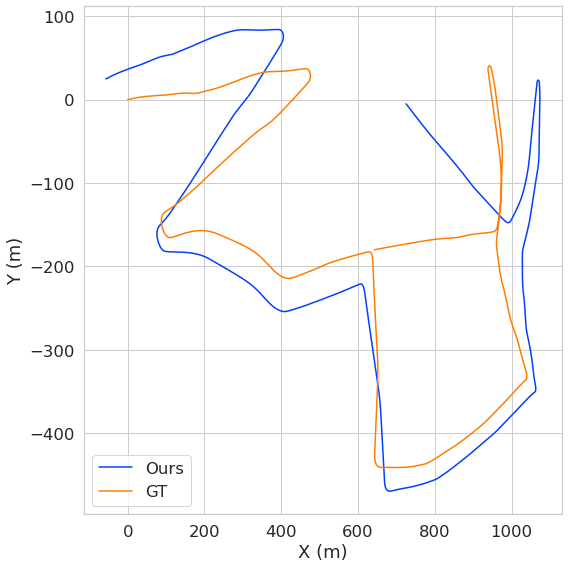

In [82]:
fig, ax = plt.subplots(figsize=(8,8))
sn.lineplot(x=np_pred[:,0], y=np_pred[:,1], sort=False, ax=ax, label='Ours')
sn.lineplot(x=gt_xyz[:,0], y=gt_xyz[:,1], sort=False, ax=ax, label='GT')

ax.set(xlabel='X (m)', ylabel='Y (m)')

# Save fig
plt.tight_layout()
plt.savefig('figs/ro_pred_gt.pdf', bbox_inches = 'tight', pad_inches = 0)

In [75]:
import warnings
def calculate_ate(pred, gt):
        """Calculate Absolute Trajectory Error between predicted and ground truth trajectories, using Umeyama alignment.
        Both prediction and gt is absolute trajectories.

        Args:
            pred (torch.Tensor): Predicted trajectory in the form of homogenous transformation matrix. Shape: [N,4,4]
            gt (torch.Tensor, optional): Absolute ground truth tracjectory in the form of homogenous transformation matrix Shape: [N,4,4]. Defaults to None.

        Returns:
            torch.Tensor: Root mean squared error (RMSE) of ATE. Scalar tensor.
        """

        # Align both trajectories to the origin
        # pred = align_to_origin(pred)
        # gt = align_to_origin(gt)

        # None for batching, batch=1
        #gt_xyz = gt[None,:,:3,3]
        # pred_xyz = pred[None,:,3:]
        #pred_xyz = pred[None,:,:3,3]
        # pred_xyz = pred_xyz - pred_xyz[0]
        #gt_xyz = gt_xyz - gt_xyz[0]
        pred = pred[None]
        gt = gt[None]
        R, T, s = corresponding_points_alignment(pred, gt)

        # apply the estimated similarity transform to Xt_init
        aligned_pred = _apply_similarity_transform(pred, R, T, s)

        # compute the root mean squared error
        rmse_ate = ((aligned_pred - gt) ** 2).mean(1).sqrt()

        return rmse_ate, aligned_pred

In [49]:
# threshold for checking that point crosscorelation
# is full rank in corresponding_points_alignment
AMBIGUOUS_ROT_SINGULAR_THR = 1e-15

def corresponding_points_alignment(
    X,
    Y,
    weights = None,
    estimate_scale: bool = False,
    allow_reflection: bool = False,
    eps: float = 1e-9,
):
    """
    Finds a similarity transformation (rotation `R`, translation `T`
    and optionally scale `s`)  between two given sets of corresponding
    `d`-dimensional points `X` and `Y` such that:

    `s[i] X[i] R[i] + T[i] = Y[i]`,

    for all batch indexes `i` in the least squares sense.

    The algorithm is also known as Umeyama [1]. Code is based on PyTorch3d.

    Args:
        **X**: Batch of `d`-dimensional points of shape `(minibatch, num_point, d)`
            or a `Pointclouds` object.
        **Y**: Batch of `d`-dimensional points of shape `(minibatch, num_point, d)`
            or a `Pointclouds` object.
        **weights**: Batch of non-negative weights of
            shape `(minibatch, num_point)` or list of `minibatch` 1-dimensional
            tensors that may have different shapes; in that case, the length of
            i-th tensor should be equal to the number of points in X_i and Y_i.
            Passing `None` means uniform weights.
        **estimate_scale**: If `True`, also estimates a scaling component `s`
            of the transformation. Otherwise assumes an identity
            scale and returns a tensor of ones.
        **allow_reflection**: If `True`, allows the algorithm to return `R`
            which is orthonormal but has determinant==-1.
        **eps**: A scalar for clamping to avoid dividing by zero. Active for the
            code that estimates the output scale `s`.

    Returns:
        3-element named tuple `SimilarityTransform` containing
        - **R**: Batch of orthonormal matrices of shape `(minibatch, d, d)`.
        - **T**: Batch of translations of shape `(minibatch, d)`.
        - **s**: batch of scaling factors of shape `(minibatch, )`.

    References:
        [1] Shinji Umeyama: Least-Suqares Estimation of
        Transformation Parameters Between Two Point Patterns
    """

    Xt = X
    Yt = Y
    num_points = torch.tensor(Xt.shape[1:-1]).to(device)
    num_points_Y = torch.tensor(Yt.shape[1:-1]).to(device)


    if (Xt.shape != Yt.shape) or (num_points != num_points_Y).any():
        raise ValueError(
            "Point sets X and Y have to have the same \
            number of batches, points and dimensions."
        )
    

    b, n, dim = Xt.shape

    # compute the centroids of the point sets
    Xmu = Xt.mean(dim=1, keepdim=True) #oputil.wmean(Xt, weight=weights, eps=eps)
    Ymu = Yt.mean(dim=1, keepdim=True) #oputil.wmean(Yt, weight=weights, eps=eps)


    # mean-center the point sets
    Xc = Xt - Xmu
    Yc = Yt - Ymu

    total_weight = torch.clamp(num_points, 1)
    # special handling for heterogeneous point clouds and/or input weights
    if weights is not None:
        Xc *= weights[:, :, None]
        Yc *= weights[:, :, None]
        total_weight = torch.clamp(weights.sum(1), eps)

    if (num_points < (dim + 1)).any():
        warnings.warn(
            "The size of one of the point clouds is <= dim+1. "
            + "corresponding_points_alignment cannot return a unique rotation."
        )

    # compute the covariance XYcov between the point sets Xc, Yc
    XYcov = torch.bmm(Xc.transpose(2, 1), Yc)
    XYcov = XYcov / total_weight[:, None, None]

    # decompose the covariance matrix XYcov
    U, S, V = torch.svd(XYcov)

    # catch ambiguous rotation by checking the magnitude of singular values
    if (S.abs() <= AMBIGUOUS_ROT_SINGULAR_THR).any() and not (
        num_points < (dim + 1)
    ).any():
        warnings.warn(
            "Excessively low rank of "
            + "cross-correlation between aligned point clouds. "
            + "corresponding_points_alignment cannot return a unique rotation."
        )

    # identity matrix used for fixing reflections
    E = torch.eye(dim, dtype=XYcov.dtype, device=XYcov.device)[None].repeat(b, 1, 1)

    if not allow_reflection:
        # reflection test:
        #   checks whether the estimated rotation has det==1,
        #   if not, finds the nearest rotation s.t. det==1 by
        #   flipping the sign of the last singular vector U
        R_test = torch.bmm(U, V.transpose(2, 1))
        E[:, -1, -1] = torch.det(R_test)

    # find the rotation matrix by composing U and V again
    R = torch.bmm(torch.bmm(U, E), V.transpose(2, 1))

    if estimate_scale:
        # estimate the scaling component of the transformation
        trace_ES = (torch.diagonal(E, dim1=1, dim2=2) * S).sum(1)
        Xcov = (Xc * Xc).sum((1, 2)) / total_weight

        # the scaling component
        s = trace_ES / torch.clamp(Xcov, eps)

        # translation component
        T = Ymu[:, 0, :] - s[:, None] * torch.bmm(Xmu, R)[:, 0, :]
    else:
        # translation component
        T = Ymu[:, 0, :] - torch.bmm(Xmu, R)[:, 0, :]

        # unit scaling since we do not estimate scale
        s = T.new_ones(b)

    return R, T, s

def _apply_similarity_transform(
    X: torch.Tensor, R: torch.Tensor, T: torch.Tensor, s: torch.Tensor
) -> torch.Tensor:
    """
    Applies a similarity transformation parametrized with a batch of orthonormal
    matrices `R` of shape `(minibatch, d, d)`, a batch of translations `T`
    of shape `(minibatch, d)` and a batch of scaling factors `s`
    of shape `(minibatch,)` to a given `d`-dimensional cloud `X`
    of shape `(minibatch, num_points, d)`
    Code is based on PyTorch3d.
    """
    X = s[:, None, None] * torch.bmm(X, R) + T[:, None, :]
    return X

# All pose analysis

In [96]:
all_poses_t = torch.cat(all_poses, 1) # [seq_length, N, 6]
all_inv_poses_t = torch.cat(all_inv_poses, 1) # [seq_length, N, 6]

In [97]:
print(all_poses_t.shape)

torch.Size([2, 2249, 6])


In [98]:
print(all_poses_t[0,:5])
print(all_inv_poses_t[0,:5])

tensor([[-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477]],
       device='cuda:0')
tensor([[-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477],
        [-4.5480, -0.9084, -1.1399,  0.1761, -0.0109, -0.1477]],
       device='cuda:0')


In [15]:
N = all_poses_t.shape[1]

In [19]:
ate_bs = []
ate_fs = []

i=0
#for i in range(k):

idx = torch.arange(i, N, k)
            


In [22]:
print(all_poses_t[0, 0])

tensor([ 0.0314, -0.0452,  0.0081,  0.0153,  0.0062,  0.0026], device='cuda:0')


In [30]:
# Previous src
b_pose = all_poses_t[1, idx]


In [31]:
print(b_pose.shape)
print(b_pose[0])

torch.Size([98, 6])
tensor([ 0.0220, -0.0847,  0.0087,  0.0214,  0.0090,  0.0085], device='cuda:0')


In [32]:
b_pose = b_pose.cumsum(dim=0) # [n,6]

In [33]:
print(b_pose.shape)
print(b_pose[0])

torch.Size([98, 6])
tensor([ 0.0220, -0.0847,  0.0087,  0.0214,  0.0090,  0.0085], device='cuda:0')


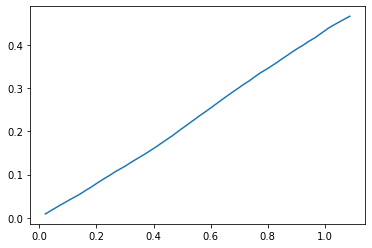

In [34]:
%matplotlib inline
plt.plot(b_pose[:,3].cpu().numpy(), b_pose[:,4].cpu().numpy())

# tgm tests

In [81]:
f_pose = torch.Tensor([
    [0,0,0,0,0,0],
    [0,0,0,2.0,0,0],
    [0,0,0,0,2,0],
    [0,0,1.57,0,0,0],
    [0,0,0,0,2,0]    
])

In [82]:
f_pose = tgm.rtvec_to_pose(f_pose)
f_pose = rel2abs_traj2(f_pose) # [n,4,4]

In [83]:
f_xyz = f_pose[:,:3,3]
print(f_xyz)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 2.0000e+00, 0.0000e+00],
        [2.0000e+00, 2.0000e+00, 0.0000e+00],
        [1.7881e-06, 2.0016e+00, 0.0000e+00]])


Text(0.5, 0, 'x')

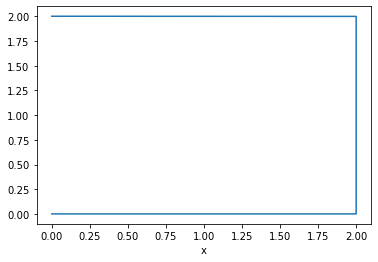

In [84]:
%matplotlib inline
plt.plot(f_xyz[:,0].cpu().numpy(), f_xyz[:,1].cpu().numpy())
plt.xlabel('x')